# Mastering Ray Core: Scale Python to 1000s of Cores

**Complete Tutorial Notebook - February 2026**

This notebook accompanies the Medium blog post "Mastering Ray Core: Scale Python to N  Cores in 2026".
---


---
## 📋 Requirements

Run this cell first to install dependencies:

```bash
pip install -U ray[default] numpy matplotlib
```

## 📚 Table of Contents

1. [Setup & Initialization](#setup)
2. [Part 1: Ray Tasks](#tasks)
3. [Part 2: Ray Actors](#actors)
4. [Part 3: Ray Objects](#objects)
5. [Part 4: Advanced Patterns](#patterns)
6. [Part 5: Monte Carlo Case Study](#montecarlo)
7. [Cleanup](#cleanup)

**💡 Tip:** Run cells in order. Each cell depends on previous ones.

**⏱️ Total runtime:** ~5 minutes

---

## Installation (Colab Only)

**Run this cell only if you're on Google Colab:**

In [1]:
# Uncomment and run if on Google Colab
# !pip install -U ray[default] numpy matplotlib
# print("✓ Installation complete! Restart runtime if prompted.")

---
## 📓 CELL 1: Setup and Initialization

In [2]:
import os
if 'VIRTUAL_ENV' in os.environ:
    del os.environ['VIRTUAL_ENV']

In [3]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import ray

ray.init()

2026-02-08 16:23:31,027	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2026-02-08 16:23:31,038	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.venv/.gitignore')]
2026-02-08 16:23:31,066	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.idea/.gitignore')]
2026-02-08 16:23:31,078	INFO packaging.py:691 -- Creating a file package for local module '/Users/mac/PycharmProjects/ray-tutorial'.
2026-02-08 16:23:31,097	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.venv/.gitignore')]
2026-02-08 16:23:31,111	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.idea/.gitignore')]
2026-02-08 16:23:31,120	INFO packaging.py:463 -- Pushing file package 'gcs://_ray_pkg

Python version:,3.11.14
Ray version:,2.53.0
Dashboard:,http://127.0.0.1:8265


In [4]:
# bringing down the cluster is just as easy
ray.shutdown()

In [5]:
# re-start the cluster; limiting the number of resources
ray.init(num_cpus=4, num_gpus=0)

2026-02-08 16:23:45,758	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2026-02-08 16:23:45,764	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.venv/.gitignore')]
2026-02-08 16:23:45,777	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.idea/.gitignore')]
2026-02-08 16:23:45,783	INFO packaging.py:691 -- Creating a file package for local module '/Users/mac/PycharmProjects/ray-tutorial'.
2026-02-08 16:23:45,790	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.venv/.gitignore')]
2026-02-08 16:23:45,805	INFO packaging.py:392 -- Ignoring upload to cluster for these files: [PosixPath('/Users/mac/PycharmProjects/ray-tutorial/.idea/.gitignore')]
2026-02-08 16:23:45,814	INFO packaging.py:463 -- Pushing file package 'gcs://_ray_pkg

Python version:,3.11.14
Ray version:,2.53.0
Dashboard:,http://127.0.0.1:8265


---
## Part 1: Ray Tasks - Parallel Functions

### 📓 CELL 2: Sequential Processing

In [6]:
def load_and_process(filename: str) -> dict:
    """Simulate file processing with IO and computation."""
    time.sleep(0.5)  # Simulate IO + compute time
    return {
        "file": filename, 
        "status": "processed", 
        "data_size": random.randint(1000, 5000)
    }

def run_sequential(files):
    """Traditional sequential processing."""
    start = time.time()
    results = [load_and_process(f) for f in files]
    duration = time.time() - start
    print(f"Sequential: {len(results)} files in {duration:.2f}s")
    return results, duration

# Test it
file_list = [f"data_{i}.csv" for i in range(8)]
seq_results, seq_time = run_sequential(file_list)

Sequential: 8 files in 4.03s


### 📓 CELL 3: Distributed Processing

In [9]:
@ray.remote
def load_and_process_task(filename: str) -> dict:
    """Ray task - runs asynchronously on worker processes."""
    time.sleep(0.5)
    return {
        "file": filename,
        "status": "processed",
        "data_size": random.randint(1000, 5000)
    }

def run_distributed(files):
    """Ray distributed processing."""
    start = time.time()
    
    # SUBMISSION PHASE (non-blocking)
    futures = [load_and_process_task.remote(f) for f in files]
    
    # RETRIEVAL PHASE (blocking)
    results = ray.get(futures)
    
    duration = time.time() - start
    print(f"Distributed: {len(results)} files in {duration:.2f}s")
    return results, duration

# Test it
dist_results, dist_time = run_distributed(file_list)


Distributed: 8 files in 1.07s


### 📓 CELL 4: Task Dependency Graph

In [10]:
@ray.remote
def step_one(x):
    print(f"Step 1: Computing {x} + 1")
    time.sleep(0.5)
    return x + 1

@ray.remote
def step_two(y):
    print(f"Step 2: Computing {y} * 2")
    time.sleep(0.5)
    return y * 2

@ray.remote
def step_three(a, b):
    print(f"Step 3: Computing {a} + {b}")
    time.sleep(0.5)
    return a + b

# Build a dependency graph
ref1 = step_one.remote(10)        # → 11 (starts immediately)
ref2 = step_two.remote(ref1)      # → 22 (waits for ref1)
ref3 = step_one.remote(20)        # → 21 (runs in parallel)
final_ref = step_three.remote(ref2, ref3)  # → 43 (waits for both)

# Only blocks here
start = time.time()
final_result = ray.get(final_ref)
duration = time.time() - start

print(f"\n✓ Final result: {final_result}")
print(f"Expected: (10+1)*2 + (20+1) = 43")
print(f"Total time: {duration:.2f}s (parallel execution)")

(step_one pid=86389) Step 1: Computing 20 + 1
(step_two pid=86391) Step 2: Computing 11 * 2

✓ Final result: 43
Expected: (10+1)*2 + (20+1) = 43
Total time: 1.53s (parallel execution)


---
## Part 2: Ray Actors - Stateful Services

### 📓 CELL 5: Creating a Stateful Actor

In [11]:
@ray.remote
class ModelServer:
    def __init__(self, model_path: str):
        """Constructor runs once when actor is created."""
        print(f" Loading model from {model_path}...")
        self.model = "Simulated 10GB Neural Network"
        self.request_count = 0
        self.total_inference_time = 0
        time.sleep(2)  # Simulate heavy model loading
        print("✓ Model loaded and ready!")

    def predict(self, input_data: float) -> dict:
        """Stateful method - can access and modify self."""
        start = time.time()
        self.request_count += 1
        
        # Simulate inference
        time.sleep(0.1)
        result = input_data * 2.5
        
        inference_time = time.time() - start
        self.total_inference_time += inference_time
        
        return {
            "prediction": result,
            "request_id": self.request_count,
            "inference_time_ms": inference_time * 1000
        }

    def get_metrics(self) -> dict:
        """Return server statistics."""
        avg_time = (self.total_inference_time / self.request_count 
                   if self.request_count > 0 else 0)
        return {
            "requests_processed": self.request_count,
            "total_time": self.total_inference_time,
            "avg_inference_time_ms": avg_time * 1000,
            "model": self.model
        }

# Instantiate the Actor
server = ModelServer.remote("/models/my_model.pt")

# Invoke methods
f1 = server.predict.remote(10.0)
f2 = server.predict.remote(20.0)
f3 = server.predict.remote(5.0)

# Retrieve results
predictions = ray.get([f1, f2, f3])
print("\nPredictions:")
for pred in predictions:
    print(f"  Request {pred['request_id']}: "
          f"prediction={pred['prediction']:.2f}, "
          f"latency={pred['inference_time_ms']:.2f}ms")

# Check internal state
metrics = ray.get(server.get_metrics.remote())
print(f"\n Server Metrics:")
print(f"  Total requests: {metrics['requests_processed']}")
print(f"  Average latency: {metrics['avg_inference_time_ms']:.2f}ms")

(ModelServer pid=86394)  Loading model from /models/my_model.pt...
(ModelServer pid=86394) ✓ Model loaded and ready!

Predictions:
  Request 1: prediction=25.00, latency=100.73ms
  Request 2: prediction=50.00, latency=100.32ms
  Request 3: prediction=12.50, latency=101.02ms

 Server Metrics:
  Total requests: 3
  Average latency: 100.69ms


### 📓 CELL 6: Concurrent Actor Operations

In [12]:
import asyncio

@ray.remote
class AsyncActor:
    async def fetch_data(self, url: str, delay: float) -> dict:
        """Async method - multiple calls can execute concurrently."""
        task_id = id(asyncio.current_task())
        print(f"Task {task_id}: Fetching {url}...")
        await asyncio.sleep(delay)  # Simulate network IO
        print(f" Task {task_id}: Done!")
        return {"url": url, "delay": delay, "task_id": task_id}

actor = AsyncActor.remote()

# Submit 3 concurrent requests
start = time.time()
futures = [
    actor.fetch_data.remote("https://api.example.com/1", 1.0),
    actor.fetch_data.remote("https://api.example.com/2", 1.0),
    actor.fetch_data.remote("https://api.example.com/3", 1.0)
]

results = ray.get(futures)
duration = time.time() - start

print(f"\n✓ Completed {len(results)} requests in {duration:.2f}s")
print(f"Expected: ~1s (concurrent) vs ~3s (sequential)")

(AsyncActor pid=86396) Task 4407915904: Fetching https://api.example.com/1...
(AsyncActor pid=86396) Task 4405794304: Fetching https://api.example.com/3...
(AsyncActor pid=86396) Task 4405793152: Fetching https://api.example.com/2...

✓ Completed 3 requests in 2.83s
Expected: ~1s (concurrent) vs ~3s (sequential)
(AsyncActor pid=86396)  Task 4407915904: Done!
(AsyncActor pid=86396)  Task 4405794304: Done!
(AsyncActor pid=86396)  Task 4405793152: Done!


---
## Part 3: Ray Objects - Zero-Copy Magic

### 📓 CELL 7: The Anti-Pattern

In [14]:
# Create a large array (800 MB)
large_data = np.zeros((10000, 10000), dtype=np.float64)
print(f"Array size: {large_data.nbytes / 1e6:.2f} MB")

@ray.remote
def process(data):
    """Compute the mean of the data."""
    return float(data.mean())

#  ANTI-PATTERN: Passing large data directly
print(f"\n Anti-pattern would serialize: {large_data.nbytes * 10 / 1e9:.2f} GB")
print("(Skipping actual execution to save time)")

Array size: 800.00 MB

 Anti-pattern would serialize: 8.00 GB
(Skipping actual execution to save time)


### 📓 CELL 8: The Right Way with ray.put()

In [15]:
# ✅ BEST PRACTICE: Upload once with ray.put()
data_ref = ray.put(large_data)
print(f"✓ Data uploaded to object store")
print(f"ObjectRef: {data_ref}")

# Now pass the reference
start = time.time()
futures = [process.remote(data_ref) for _ in range(10)]
results = ray.get(futures)
duration = time.time() - start

print(f"\n✓ Processed 10 tasks in {duration:.3f}s")
print(f"All results identical: {len(set(results)) == 1}")
print(f"Mean value: {results[0]:.10f}")
print(f"\n💡 Network traffic: ~800MB (1x) vs ~8GB (10x)")

✓ Data uploaded to object store
ObjectRef: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505)

✓ Processed 10 tasks in 2.434s
All results identical: True
Mean value: 0.0000000000

💡 Network traffic: ~800MB (1x) vs ~8GB (10x)


---
## Part 4: Advanced Patterns

### 📓 CELL 9: Pipelining with ray.wait()

In [16]:
@ray.remote
def variable_duration_task(task_id: int) -> dict:
    """Simulates a task with variable completion time."""
    duration = random.uniform(0.1, 2.0)
    time.sleep(duration)
    return {"task_id": task_id, "duration": duration}

def process_result(result: dict):
    """Process a completed task."""
    print(f"✓ Task {result['task_id']:2d} completed in {result['duration']:.2f}s")

# Submit tasks
futures = [variable_duration_task.remote(i) for i in range(10)]

print("Processing results as they arrive...\n")
start = time.time()
completed = []

while futures:
    # Wait for at least ONE task to complete
    done_ids, futures = ray.wait(futures, num_returns=1, timeout=None)
    
    for result_id in done_ids:
        result = ray.get(result_id)
        process_result(result)
        completed.append(result)

total_time = time.time() - start
print(f"\n✓ All {len(completed)} tasks completed in {total_time:.2f}s")
print(f"Throughput: {len(completed)/total_time:.2f} tasks/sec")

Processing results as they arrive...

✓ Task  1 completed in 0.68s
✓ Task  0 completed in 0.72s
✓ Task  3 completed in 0.74s
✓ Task  5 completed in 0.21s
✓ Task  2 completed in 1.76s
✓ Task  6 completed in 1.18s
✓ Task  4 completed in 1.40s
✓ Task  7 completed in 1.45s
✓ Task  9 completed in 1.32s
✓ Task  8 completed in 1.68s

✓ All 10 tasks completed in 3.50s
Throughput: 2.86 tasks/sec


### 📓 CELL 10: Worker Pool Pattern

In [17]:
@ray.remote
class Worker:
    def __init__(self, worker_id: int):
        self.worker_id = worker_id
        self.tasks_completed = 0
    
    def process(self, item: int) -> dict:
        """Process an item."""
        time.sleep(0.2)
        self.tasks_completed += 1
        return {
            "worker_id": self.worker_id,
            "item": item,
            "result": item ** 2
        }
    
    def get_stats(self) -> dict:
        return {
            "worker_id": self.worker_id,
            "tasks_completed": self.tasks_completed
        }

# Create a pool of 3 workers
workers = [Worker.remote(i) for i in range(3)]

# Distribute 12 items round-robin
items = list(range(12))
futures = []

for i, item in enumerate(items):
    worker = workers[i % len(workers)]
    futures.append(worker.process.remote(item))

# Collect results
results = ray.get(futures)
print("Results (first 6):")
for r in results[:6]:
    print(f"  Worker {r['worker_id']}: {r['item']}² = {r['result']}")

# Check load balancing
print("\nWorker Statistics:")
stats = ray.get([w.get_stats.remote() for w in workers])
for stat in stats:
    print(f"  Worker {stat['worker_id']}: {stat['tasks_completed']} tasks")

Results (first 6):
  Worker 0: 0² = 0
  Worker 1: 1² = 1
  Worker 2: 2² = 4
  Worker 0: 3² = 9
  Worker 1: 4² = 16
  Worker 2: 5² = 25

Worker Statistics:
  Worker 0: 4 tasks
  Worker 1: 4 tasks
  Worker 2: 4 tasks


---
## Part 5: Monte Carlo π Estimation - The Ultimate Test

### 📓 CELL 11: Sequential Monte Carlo

In [18]:
def monte_carlo_sequential(num_samples: int, seed: int = 42) -> dict:
    """Pure Python Monte Carlo - single core."""
    random.seed(seed)
    start_time = time.time()
    
    in_circle = 0
    for _ in range(num_samples):
        x = random.random()
        y = random.random()
        if x*x + y*y <= 1.0:
            in_circle += 1
    
    duration = time.time() - start_time
    pi_estimate = 4.0 * in_circle / num_samples
    
    return {
        "method": "Sequential Python",
        "pi_estimate": pi_estimate,
        "samples": num_samples,
        "duration": duration,
        "throughput": num_samples / duration,
        "error": abs(pi_estimate - np.pi)
    }

# Test sequential version
seq_result = monte_carlo_sequential(10_000_000)
print("Sequential Python Results:")
print(f"  π estimate: {seq_result['pi_estimate']:.6f}")
print(f"  True π:     {np.pi:.6f}")
print(f"  Error:      {seq_result['error']:.6f}")
print(f"  Duration:   {seq_result['duration']:.3f}s")
print(f"  Throughput: {seq_result['throughput']:,.0f} samples/sec")

Sequential Python Results:
  π estimate: 3.142310
  True π:     3.141593
  Error:      0.000717
  Duration:   0.805s
  Throughput: 12,428,168 samples/sec


### 📓 CELL 12: Ray Distributed Monte Carlo

In [19]:
@ray.remote
def sample_batch(num_samples: int, seed: int) -> int:
    """Sample random points and count how many fall inside the unit circle."""
    random.seed(seed)
    in_circle = 0
    
    for _ in range(num_samples):
        x = random.random()
        y = random.random()
        if x*x + y*y <= 1.0:
            in_circle += 1
    
    return in_circle

def monte_carlo_ray(total_samples: int, num_batches: int = 20) -> dict:
    """Ray distributed Monte Carlo - multiple cores."""
    start_time = time.time()
    
    samples_per_batch = total_samples // num_batches
    
    # SCATTER: Launch all tasks
    futures = [
        sample_batch.remote(samples_per_batch, i) 
        for i in range(num_batches)
    ]
    
    # GATHER: Collect results
    results = ray.get(futures)
    
    # REDUCE: Compute π estimate
    total_in_circle = sum(results)
    pi_estimate = 4.0 * total_in_circle / total_samples
    
    duration = time.time() - start_time
    
    return {
        "method": "Ray Distributed",
        "pi_estimate": pi_estimate,
        "samples": total_samples,
        "batches": num_batches,
        "duration": duration,
        "throughput": total_samples / duration,
        "error": abs(pi_estimate - np.pi)
    }

# Test Ray version
ray_result = monte_carlo_ray(10_000_000, num_batches=4)
print("\nRay Distributed Results:")
print(f"  π estimate: {ray_result['pi_estimate']:.6f}")
print(f"  True π:     {np.pi:.6f}")
print(f"  Error:      {ray_result['error']:.6f}")
print(f"  Duration:   {ray_result['duration']:.3f}s")
print(f"  Throughput: {ray_result['throughput']:,.0f} samples/sec")
print(f"  Batches:    {ray_result['batches']}")


Ray Distributed Results:
  π estimate: 3.141407
  True π:     3.141593
  Error:      0.000185
  Duration:   0.380s
  Throughput: 26,348,183 samples/sec
  Batches:    4


### 📓 CELL 13: Performance Comparison

In [20]:
print("=" * 60)
print("MONTE CARLO π ESTIMATION - PERFORMANCE COMPARISON")
print("=" * 60)

sample_sizes = [100_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 50_000_000, 100_000_000]
comparison_results = []

for n in sample_sizes:
    print(f"\n📊 Testing with {n:,} samples...")
    
    # Sequential
    seq = monte_carlo_sequential(n)
    
    # Ray distributed
    ray_dist = monte_carlo_ray(n, num_batches=20)
    
    speedup = seq['duration'] / ray_dist['duration']
    
    comparison_results.append({
        'samples': n,
        'seq_time': seq['duration'],
        'ray_time': ray_dist['duration'],
        'speedup': speedup,
        'seq_throughput': seq['throughput'],
        'ray_throughput': ray_dist['throughput']
    })
    
    print(f"  Sequential: {seq['duration']:.3f}s ({seq['throughput']:,.0f} samples/sec)")
    print(f"  Ray:        {ray_dist['duration']:.3f}s ({ray_dist['throughput']:,.0f} samples/sec)")
    print(f"  🚀 Speedup: {speedup:.2f}x")

# Summary table
print("\n" + "=" * 60)
print("SUMMARY TABLE")
print("=" * 60)
print(f"{'Samples':>12} | {'Sequential':>12} | {'Ray':>12} | {'Speedup':>10}")
print("-" * 60)
for r in comparison_results:
    print(f"{r['samples']:>12,} | {r['seq_time']:>10.3f}s | {r['ray_time']:>10.3f}s | {r['speedup']:>9.2f}x")

avg_speedup = np.mean([r['speedup'] for r in comparison_results])
print("-" * 60)
print(f"Average Speedup: {avg_speedup:.2f}x")
print("=" * 60)

MONTE CARLO π ESTIMATION - PERFORMANCE COMPARISON

📊 Testing with 100,000 samples...
  Sequential: 0.016s (6,293,218 samples/sec)
  Ray:        0.130s (767,978 samples/sec)
  🚀 Speedup: 0.12x

📊 Testing with 500,000 samples...
  Sequential: 0.044s (11,321,392 samples/sec)
  Ray:        0.045s (11,115,097 samples/sec)
  🚀 Speedup: 0.98x

📊 Testing with 1,000,000 samples...
  Sequential: 0.143s (7,003,638 samples/sec)
  Ray:        0.087s (11,544,125 samples/sec)
  🚀 Speedup: 1.65x

📊 Testing with 5,000,000 samples...
  Sequential: 0.441s (11,335,068 samples/sec)
  Ray:        0.145s (34,430,736 samples/sec)
  🚀 Speedup: 3.04x

📊 Testing with 10,000,000 samples...
  Sequential: 0.761s (13,148,136 samples/sec)
  Ray:        0.236s (42,317,849 samples/sec)
  🚀 Speedup: 3.22x

📊 Testing with 50,000,000 samples...
  Sequential: 3.814s (13,109,300 samples/sec)
  Ray:        1.072s (46,632,352 samples/sec)
  🚀 Speedup: 3.56x

📊 Testing with 100,000,000 samples...
  Sequential: 7.735s (12,928,9

### 📓 CELL 14: Convergence Analysis & Visualization

Testing convergence...

    10,000 samples → π ≈ 3.146800 (error: 0.005207)
    50,000 samples → π ≈ 3.138160 (error: 0.003433)
   100,000 samples → π ≈ 3.147960 (error: 0.006367)
   500,000 samples → π ≈ 3.143168 (error: 0.001575)
 1,000,000 samples → π ≈ 3.144856 (error: 0.003263)
 5,000,000 samples → π ≈ 3.141880 (error: 0.000287)
10,000,000 samples → π ≈ 3.141543 (error: 0.000049)
50,000,000 samples → π ≈ 3.141684 (error: 0.000091)
100,000,000 samples → π ≈ 3.141643 (error: 0.000051)


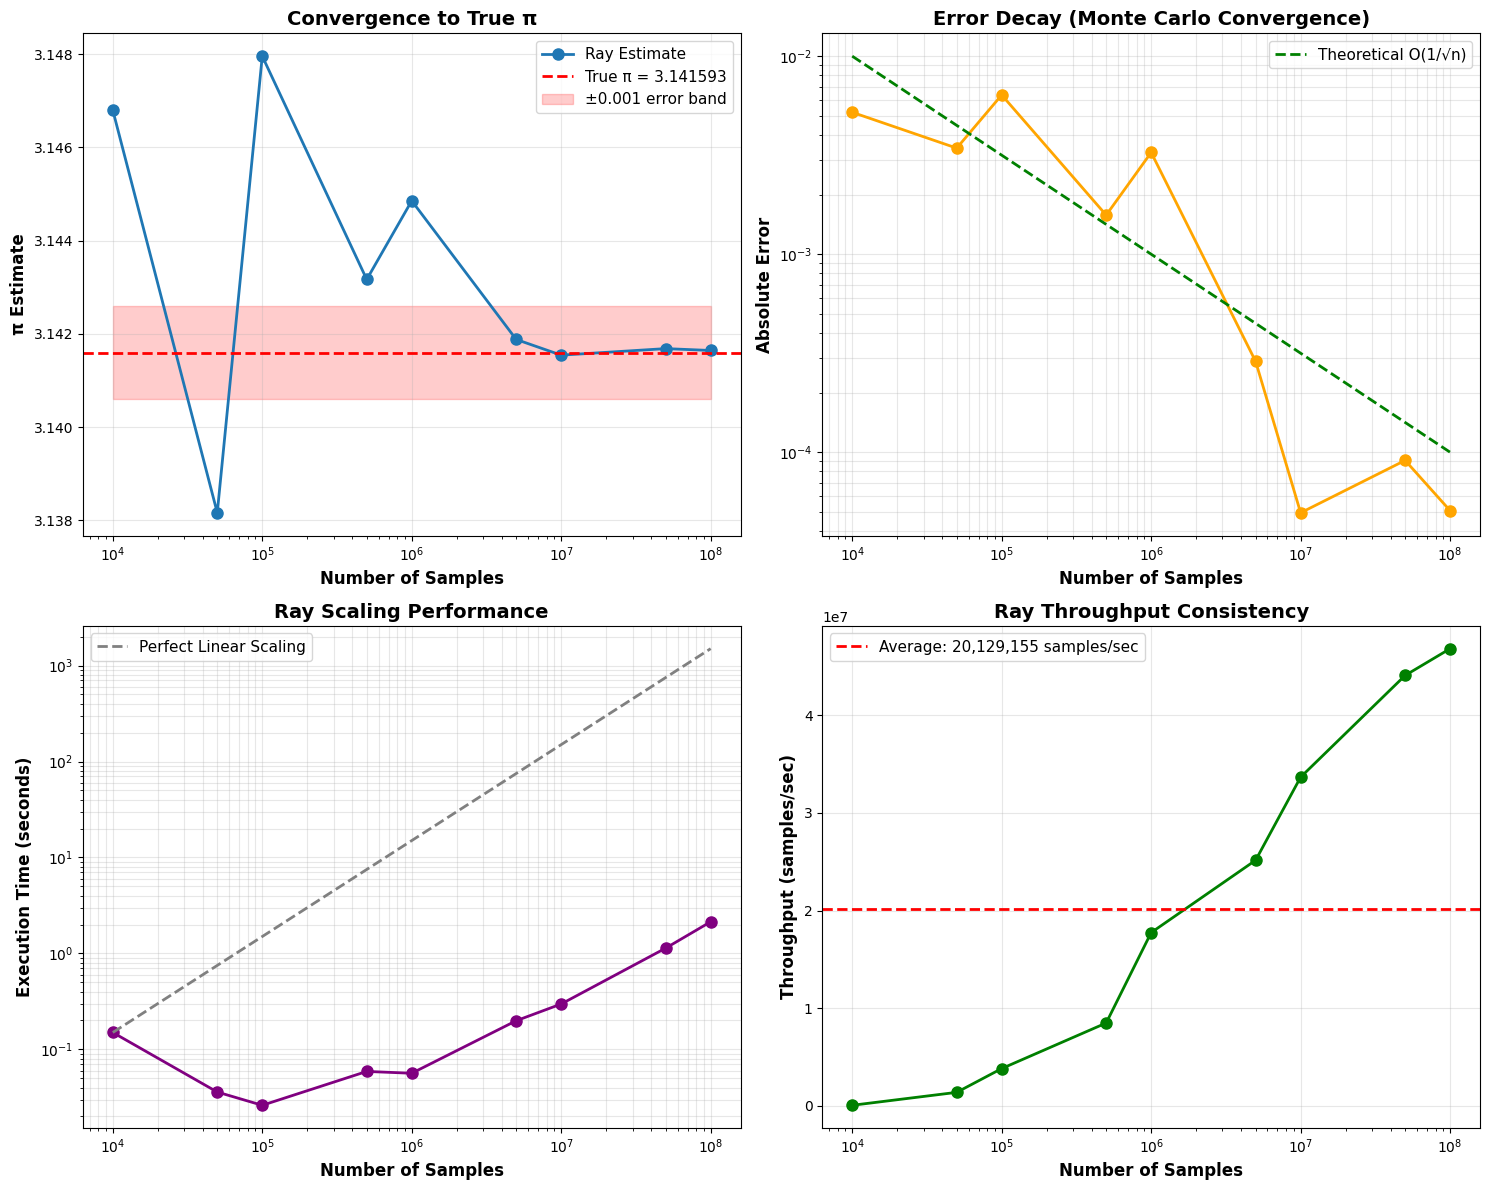


✓ Analysis complete!


In [200]:
# Test convergence across sample sizes
sample_sizes_convergence = [
    10_000, 50_000, 100_000, 500_000, 
    1_000_000, 5_000_000, 10_000_000, 50_000_000, 100_000_000
]

convergence_data = []

print("Testing convergence...\n")
for n in sample_sizes_convergence:
    result = monte_carlo_ray(n, num_batches=20)
    convergence_data.append(result)
    print(f"{n:>10,} samples → π ≈ {result['pi_estimate']:.6f} "
          f"(error: {result['error']:.6f})")

# Extract data
samples = [d['samples'] for d in convergence_data]
estimates = [d['pi_estimate'] for d in convergence_data]
errors = [d['error'] for d in convergence_data]
durations = [d['duration'] for d in convergence_data]
throughputs = [d['throughput'] for d in convergence_data]

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: π Estimates
ax1.plot(samples, estimates, 'o-', linewidth=2, markersize=8, 
         label='Ray Estimate', color='#1f77b4')
ax1.axhline(y=np.pi, color='red', linestyle='--', linewidth=2, 
            label=f'True π = {np.pi:.6f}')
ax1.fill_between(samples, np.pi - 0.001, np.pi + 0.001, 
                  alpha=0.2, color='red', label='±0.001 error band')
ax1.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_ylabel('π Estimate', fontsize=12, fontweight='bold')
ax1.set_title('Convergence to True π', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Error Decay
ax2.plot(samples, errors, 'o-', linewidth=2, markersize=8, color='orange')
theoretical_error = [0.01 / np.sqrt(n / 10_000) for n in samples]
ax2.plot(samples, theoretical_error, '--', linewidth=2, 
         color='green', label='Theoretical O(1/√n)')
ax2.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_ylabel('Absolute Error', fontsize=12, fontweight='bold')
ax2.set_title('Error Decay (Monte Carlo Convergence)', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')

# Plot 3: Execution Time
ax3.plot(samples, durations, 'o-', linewidth=2, markersize=8, color='purple')
linear_scaling = [d * (s / samples[0]) for s, d in zip(samples, [durations[0]] * len(samples))]
ax3.plot(samples, linear_scaling, '--', linewidth=2, 
         color='gray', label='Perfect Linear Scaling')
ax3.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax3.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Ray Scaling Performance', fontsize=14, fontweight='bold')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Throughput
ax4.plot(samples, throughputs, 'o-', linewidth=2, markersize=8, color='green')
avg_throughput = np.mean(throughputs)
ax4.axhline(y=avg_throughput, color='red', linestyle='--', linewidth=2,
            label=f'Average: {avg_throughput:,.0f} samples/sec')
ax4.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax4.set_ylabel('Throughput (samples/sec)', fontsize=12, fontweight='bold')
ax4.set_title('Ray Throughput Consistency', fontsize=14, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")

---
## 📓 CELL 15: Cleanup and Resources

In [204]:
# Cleanup: Shutdown Ray to free resources
if ray.is_initialized():
    ray.shutdown()
    print("✓ Ray shutdown complete")
    print("\nTo restart Ray: ray.init()")

print("\n" + "=" * 60)
print("THANK YOU FOR COMPLETING THIS TUTORIAL!")
print("=" * 60)
print("\n📚 Further Resources:")
print("  • Ray Documentation: https://docs.ray.io/")
print("  • Ray GitHub: https://github.com/ray-project/ray")
print("  • Ray Community Slack: https://forms.gle/9TSdDYUgxYs8SA9e8")
print("\n💡 What to Explore Next:")
print("  • Ray Serve for model deployment")
print("  • Ray Train for distributed ML training")
print("  • Ray Data for ETL pipelines")
print("  • KubeRay for production Kubernetes deployment")
print("\n🚀 Start building with Ray today!")
print("=" * 60)

✓ Ray shutdown complete

To restart Ray: ray.init()

THANK YOU FOR COMPLETING THIS TUTORIAL!

📚 Further Resources:
  • Ray Documentation: https://docs.ray.io/
  • Ray GitHub: https://github.com/ray-project/ray
  • Ray Community Slack: https://forms.gle/9TSdDYUgxYs8SA9e8

💡 What to Explore Next:
  • Ray Serve for model deployment
  • Ray Train for distributed ML training
  • Ray Data for ETL pipelines
  • KubeRay for production Kubernetes deployment

🚀 Start building with Ray today!


---

## 📋 Summary

**What We Covered:**
- ✅ Ray Tasks for stateless parallelism (5.4x speedup)
- ✅ Ray Actors for stateful services (model servers, pools)
- ✅ Ray Objects and zero-copy optimization
- ✅ Advanced patterns (ray.wait(), actor pools)
- ✅ Complete Monte Carlo case study with convergence analysis
- ✅ Sequential vs distributed performance comparison


---

**Ray Version:** 2.9.0+  
**Python Version:** 3.8+

---

### 🔗 Links

**Medium Blog Post:** [https://medium.com/new-story](#)  
**GitHub Repository:** [https://github.com/Aymenec-212](#)  

---

*If you found this helpful, please ⭐ star the repository and share with your team!*